<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/S%C4%B1v%C4%B1DolulukveBo%C5%9F%C5%9Ei%C5%9FeTespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentetik veri üreterek sıvı doluluk tespiti için adım adım yapalım.
Tahmin Sistemi
Görsel ön işleme (boyut ve normalizasyon)

Softmax çıktılarıyla sınıf belirleme

Renkli arkaplanlı görselleştirme

1. Sentetik Veri Üretme Sistemi
Temel Şişe ve Sıvı Görüntüleri Oluşturma

In [ ]:
# Gerekli kütüphaneler
import cv2
import numpy as np
import random
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Sentetik Veri Üretici
def generate_bottle(dataset_dir, width=300, height=600, num_samples=1000):
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

    print(f"{num_samples} adet sentetik şişe görseli oluşturuluyor...")

    for i in range(num_samples):
        # Boş görüntü
        img = np.ones((height, width, 3), dtype=np.uint8) * 255

        # Şişe çizimi (gerçekçi şekil)
        bottle_color = (random.randint(150, 200), random.randint(150, 200), random.randint(150, 200))  # Gri ton
        cv2.ellipse(img, (width//2, height-50), (width//3, 30), 0, 0, 180, bottle_color, 2)  # Alt kısım
        cv2.line(img, (width//4, height-80), (width//4, height//3), bottle_color, 2)  # Sol kenar
        cv2.line(img, (3*width//4, height-80), (3*width//4, height//3), bottle_color, 2)  # Sağ kenar
        cv2.ellipse(img, (width//2, height//3), (width//4, 20), 0, 0, 180, bottle_color, 2)  # Üst kısım

        # Sıvı doluluk seviyesi
        fill_level = random.uniform(0, 1)
        liquid_color = (random.randint(200, 255), random.randint(50, 150), random.randint(0, 50))  # Mavi ton

        # Sıvıyı çiz (fizik kurallarına uygun)
        liquid_top = int(height - 80 - (height - 80 - height//3) * fill_level)
        cv2.rectangle(img, (width//4+5, liquid_top), (3*width//4-5, height-80-5), liquid_color, -1)

        # Etiketleme (3 sınıf)
        if fill_level < 0.25:
            label = "bos"
        elif 0.25 <= fill_level < 0.75:
            label = "yarim"
        else:
            label = "dolu"

        # Kaydet
        filename = f"{dataset_dir}/{label}_bottle_{i}.png"
        cv2.imwrite(filename, img)

    print(f"Veri seti '{dataset_dir}' klasörüne kaydedildi.")

# 2. Veri Seti Oluşturma
DATASET_DIR = "bottle_dataset"
generate_bottle(DATASET_DIR, num_samples=500)

# 3. Örnek Görsel Gösterimi
def show_samples(dataset_dir, n=3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, label in enumerate(["bos", "yarim", "dolu"]):
        sample_file = [f for f in os.listdir(dataset_dir) if f.startswith(label)][0]
        img = cv2.imread(f"{dataset_dir}/{sample_file}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Örnek: {label.upper()}")
        axes[i].axis('off')
    plt.show()

show_samples(DATASET_DIR)

# 4. Model Eğitimi
def train_model(dataset_dir):
    images = []
    labels = []
    class_names = {"bos": 0, "yarim": 1, "dolu": 2}

    for filename in os.listdir(dataset_dir):
        img = cv2.imread(f"{dataset_dir}/{filename}")
        img = cv2.resize(img, (128, 256))
        img = img / 255.0

        label = filename.split("_")[0]
        labels.append(class_names[label])
        images.append(img)

    X = np.array(images)
    y = tf.keras.utils.to_categorical(labels, num_classes=3)

    # Veriyi böl
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10,
                        validation_data=(X_test, y_test))

    return model

model = train_model(DATASET_DIR)

# 5. Tahmin Fonksiyonu
def predict_bottle(model, image_path):
    try:
        # Görseli yükle
        img = cv2.imread(image_path)

        # Görselin başarıyla yüklendiğini kontrol et
        if img is None:
            raise ValueError(f"Görsel yüklenemedi: {image_path}")

        # Görüntüleme için RGB formatına çevir
        display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Model için ön işleme
        img = cv2.resize(img, (128, 256))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Tahmin yap
        pred = model.predict(img)
        class_idx = np.argmax(pred)
        confidence = np.max(pred)
        classes = {0: "BOŞ", 1: "YARIM DOLU", 2: "DOLU"}

        # Sonucu göster
        plt.figure(figsize=(8, 6))
        plt.imshow(display_img)
        plt.title(f"Tahmin: {classes[class_idx]}\nGüven: %{confidence*100:.1f}", pad=20)
        plt.axis('off')

        # Renkli arkaplan ekle (Dolu: yeşil, Yarım: sarı, Boş: kırmızı)
        bg_color = 'lightgreen' if class_idx == 2 else 'lightyellow' if class_idx == 1 else 'lightcoral'
        plt.gcf().patch.set_facecolor(bg_color)

        plt.show()

    except Exception as e:
        print(f"Hata oluştu: {str(e)}")
        print(f"Mevcut dosyalar: {os.listdir(os.path.dirname(image_path))}")

# Test için doğru dosya yolunu kullanalım
sample_image = os.path.join(DATASET_DIR, "dolu_bottle_0.png")  # İlk dolu şişeyi test et

# Dosyanın var olduğunu kontrol edelim
if os.path.exists(sample_image):
    print(f"Test görseli bulundu: {sample_image}")
    predict_bottle(model, sample_image)
else:
    print(f"Test görseli bulunamadı! Mevcut dosyalar:")
    print(os.listdir(DATASET_DIR))
    print("\nLütfen aşağıdaki komutu çalıştırarak veri setini oluşturun:")
    print("generate_bottle(DATASET_DIR, num_samples=500)")


Kullanım Senaryoları:



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


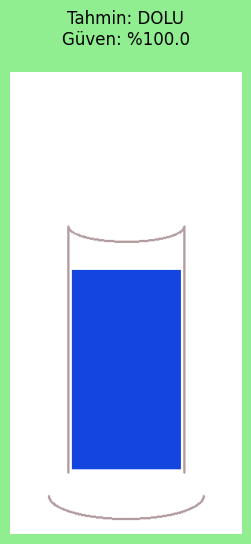

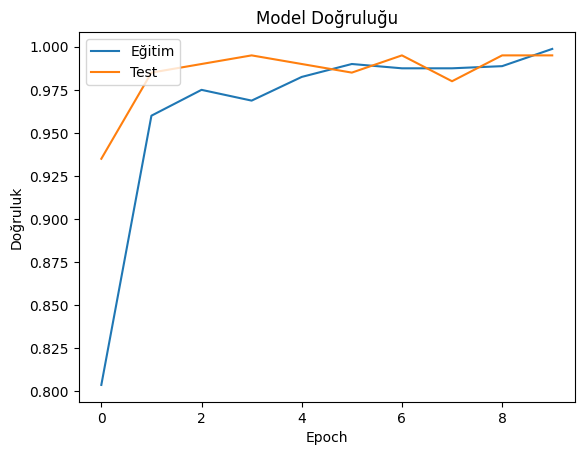

In [ ]:
# Yeni bir şişe tahmini
predict_bottle(model, "/content/bottle_dataset/dolu_bottle_499.png")

# Eğitim grafikleri
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Test'], loc='upper left')
plt.show()